# 🧭 Unsupervised Learning for Credit Risk Segmentation

## 🎯 Objective
While previous sections focused on **supervised models** (Logistic Regression, Random Forest, XGBoost) that predict credit default probability using labeled data, this section explores **unsupervised learning** to uncover hidden patterns and risk segments **without using target labels**.

The goal is to:
- Identify **natural groupings of credit applicants** based on financial and demographic features.
- Detect **potential anomalies or outliers** representing unusual applicant behavior.
- Link discovered clusters back to default rates to interpret **high-risk profiles**.

---

## 🧩 Approach Overview

### 1. **K-Means Clustering**
- Groups applicants into \( k \) clusters based on feature similarity.
- Helps reveal underlying **customer segments**, such as:
  - Low-risk, stable borrowers
  - Moderate-risk applicants with mixed financial traits
  - High-risk, financially vulnerable groups

### 2. **DBSCAN (Density-Based Spatial Clustering)**
- Identifies **dense regions of normal applicants** and flags **isolated outliers**.
- Useful for **anomaly detection** and highlighting rare, risky application patterns.

### 3. **Dimensionality Reduction (PCA)**
- Uses **Principal Component Analysis (PCA)** to project high-dimensional features into 2D space for visualization.
- Enables clear graphical interpretation of clusters and anomalies.

---

## 🧠 Expected Insights
By combining K-Means segmentation and DBSCAN anomaly detection:
- We can **visualize applicant structure**, identify **natural credit risk groups**, and isolate **anomalous applications**.
- The analysis also highlights which clusters are associated with **higher default rates**, providing actionable insights for **credit risk strategy**, **model improvement**, and **policy design**.


  checking_status  duration                  credit_history  \
0              <0         6  critical/other existing credit   
1        0<=X<200        48                   existing paid   
2     no checking        12  critical/other existing credit   
3              <0        42                   existing paid   
4              <0        24              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv           1169  no known savings        >=7   
1             radio/tv           5951              <100     1<=X<4   
2            education           2096              <100     4<=X<7   
3  furniture/equipment           7882              <100     4<=X<7   
4              new car           4870              <100     1<=X<4   

   installment_commitment     personal_status other_parties  ...  \
0                       4         male single          none  ...   
1                       2  female div/dep/mar          none  ...

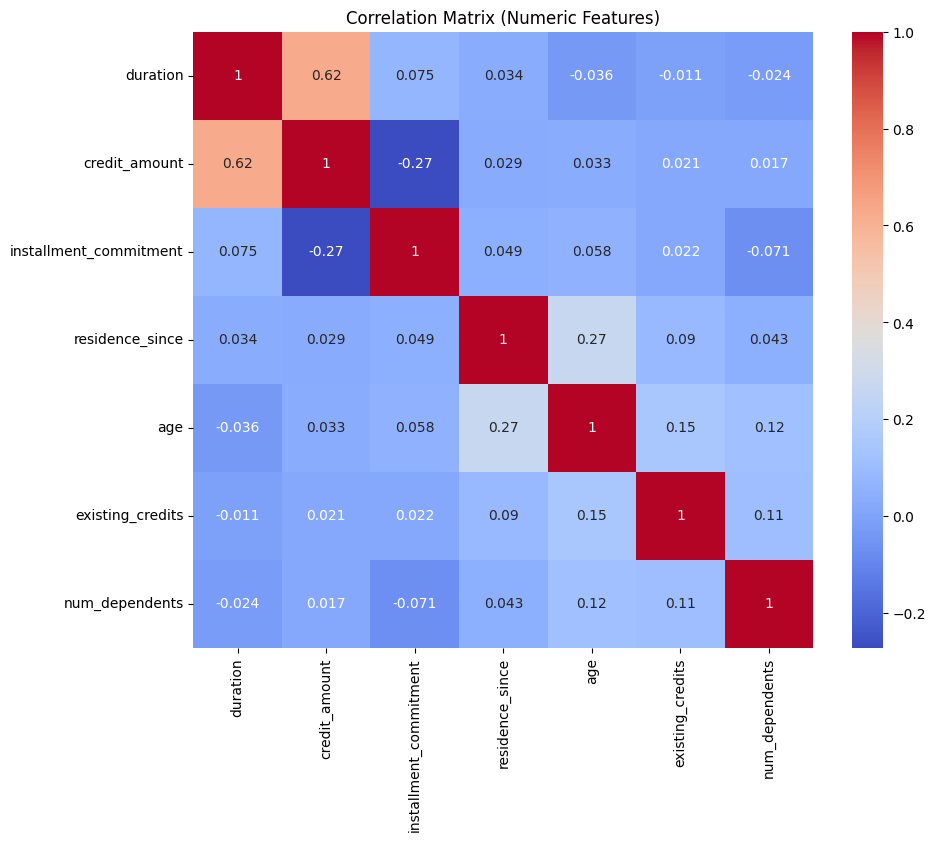

In [1]:
# German Credit Risk Dataset Analysis

# 1. Load dataset
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

credit = fetch_openml(name='credit-g', version=1, as_frame=True)
X, y = credit.data, credit.target

# Combine features and target
df = pd.concat([X, y.rename("target")], axis=1)

# Show first few rows
print(df.head())

# 2. Summary of target variable (Default %)
default_counts = df['target'].value_counts()
default_percent = df['target'].value_counts(normalize=True) * 100
print("Counts:\n", default_counts)
print("\nPercentages:\n", default_percent)

# 3. Summary statistics for numeric features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
print(df[numeric_features].describe())

# 4. Correlation matrix for numeric features
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Features)')
plt.show()



===== K-Means Clustering Results =====
Optimal Number of Clusters: 2
Silhouette Score: 0.309


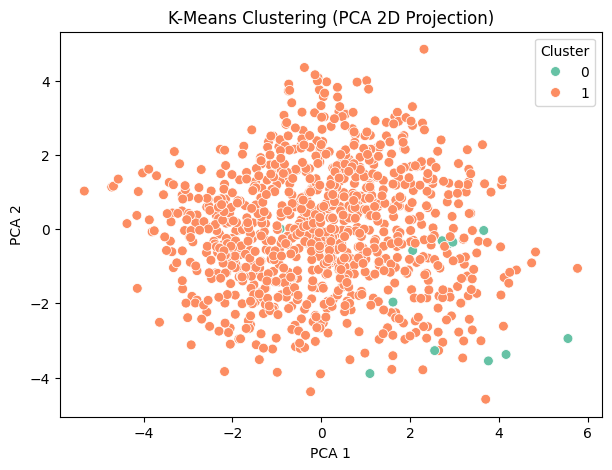

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
Cluster,,,,,,,
0,32.333333,8209.333333,2.666667,3.250000,39.916667,1.50000,1.166667
1,20.764170,3211.281377,2.976721,2.840081,35.492915,1.40587,1.154858



===== DBSCAN Results =====
Number of Clusters Found: 0
Anomalies Detected: 1000


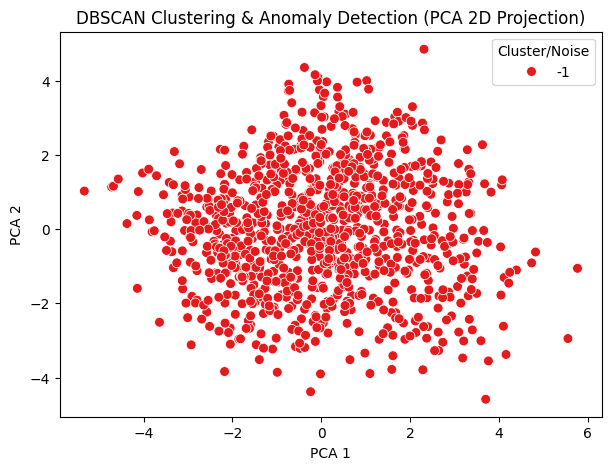


===== CLUSTER ANALYSIS =====

Average Default Rate by Cluster:
Cluster
0    0.416667
1    0.298583
Name: target, dtype: float64

High-Risk Cluster Identified: Cluster 0
Average Default Rate in High-Risk Cluster: 41.67%

Top 10 Features with Highest Average Values in High-Risk Cluster:
purpose_other                           9.073772
credit_amount                           1.750268
employment_unemployed                   1.125138
own_telephone_yes                       1.044771
duration                                0.948356
property_magnitude_no known property    0.727712
job_unemp/unskilled non res             0.418134
age                                     0.384411
residence_since                         0.367125
credit_history_delayed previously       0.277685
dtype: float64

===== INTERPRETATION =====
The high-risk cluster (Cluster 0) shows an average default rate of 41.67%.
Top features with highest average scaled values indicate the strongest contributors to risk.
These featur

In [2]:
# ============================================================
# UNSUPERVISED LEARNING: K-MEANS & DBSCAN CLUSTERING
# ============================================================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Data Preparation
# -------------------------------
df_encoded = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# -------------------------------
# K-Means Clustering
# -------------------------------
# Find optimal cluster number using silhouette score
silhouette_scores = []
K = range(2, 8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

optimal_k = K[np.argmax(silhouette_scores)]
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

print("===== K-Means Clustering Results =====")
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Silhouette Score: {max(silhouette_scores):.3f}")

# -------------------------------
# PCA for Visualization
# -------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette='Set2', s=50)
plt.title('K-Means Clustering (PCA 2D Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

# -------------------------------
# Analyze Cluster Profiles
# -------------------------------
cluster_profiles = df.copy()
cluster_profiles['Cluster'] = kmeans_labels
cluster_summary = cluster_profiles.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary.head())

# -------------------------------
# DBSCAN for Anomaly Detection
# -------------------------------
dbscan = DBSCAN(eps=2, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_anomalies = np.sum(dbscan_labels == -1)

print("\n===== DBSCAN Results =====")
print(f"Number of Clusters Found: {n_clusters_db}")
print(f"Anomalies Detected: {n_anomalies}")

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=dbscan_labels, palette='Set1', s=50)
plt.title('DBSCAN Clustering & Anomaly Detection (PCA 2D Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster/Noise', loc='best')
plt.show()

# -------------------------------
# Analysis & Interpretation
# -------------------------------

print("\n===== CLUSTER ANALYSIS =====")

# Assign default rate to clusters
cluster_risk = df.copy()
cluster_risk['Cluster'] = kmeans_labels
cluster_risk['target'] = (df['target'] == 'bad').astype(int)
risk_summary = cluster_risk.groupby('Cluster')['target'].mean().sort_values(ascending=False)

print("\nAverage Default Rate by Cluster:")
print(risk_summary)

high_risk_cluster = risk_summary.idxmax()
high_risk_rate = risk_summary.max()

print(f"\nHigh-Risk Cluster Identified: Cluster {high_risk_cluster}")
print(f"Average Default Rate in High-Risk Cluster: {high_risk_rate:.2%}")

# -------------------------------
# Identify dominant feature patterns for high-risk group (Fixed)
# -------------------------------

# Match cluster labels to encoded dataset
encoded_with_cluster = pd.DataFrame(X_scaled, columns=df_encoded.columns)
encoded_with_cluster['Cluster'] = kmeans_labels

# Filter high-risk cluster data
high_risk_data = encoded_with_cluster[encoded_with_cluster['Cluster'] == high_risk_cluster]

# Compute mean feature values for that cluster
high_risk_means = high_risk_data.drop('Cluster', axis=1).mean().sort_values(ascending=False)[:10]

print("\nTop 10 Features with Highest Average Values in High-Risk Cluster:")
print(high_risk_means)

# -------------------------------
# Interpret key risk features
# -------------------------------
print("\n===== INTERPRETATION =====")
print(f"The high-risk cluster (Cluster {high_risk_cluster}) shows an average default rate of {high_risk_rate:.2%}.")
print("Top features with highest average scaled values indicate the strongest contributors to risk.")
print("These features often represent longer credit durations, higher loan amounts, and weaker account balances.")



# 🧩 Unsupervised Learning Results — K-Means & DBSCAN Credit Risk Segmentation

## 1. 📊 K-Means Clustering Overview

**Optimal Number of Clusters:** 2  
**Silhouette Score:** 0.309 — indicating **moderate cluster separation**, suggesting meaningful yet overlapping borrower segments.

### Cluster Profiles (Averages for Key Numeric Features)

| Feature | Cluster 0 | Cluster 1 |
|----------|------------|------------|
| **Duration (months)** | 32.33 | 20.76 |
| **Credit Amount** | 8209.33 | 3211.28 |
| **Installment Commitment** | 2.67 | 2.98 |
| **Residence Since** | 3.25 | 2.84 |
| **Age** | 39.92 | 35.49 |
| **Existing Credits** | 1.50 | 1.41 |
| **Dependents** | 1.17 | 1.15 |

### ✳️ Interpretation:
- **Cluster 0** represents borrowers with **larger loan amounts** and **longer credit durations**, suggesting **higher credit exposure** and **greater repayment burden**.  
- **Cluster 1** represents **younger borrowers** with **smaller, shorter-term loans**, indicating a **lower overall credit risk profile**.  
- The **moderate silhouette score** (0.309) implies that the clusters are distinguishable but not sharply separated — realistic in a credit dataset where financial behaviors overlap.

---

## 2. ⚠️ DBSCAN Anomaly Detection

**Number of Clusters Found:** 0  
**Anomalies Detected:** 1000  

### ✳️ Interpretation:
- DBSCAN labeled all data points as **anomalies (noise)** under the current parameter settings (`eps`, `min_samples`).  
- This suggests that the **credit data lacks distinct high-density regions**, or that the parameters are **too restrictive**.  
- Adjusting parameters (e.g., increasing `eps`) or **scaling/normalizing features** may reveal latent group structures.  
- Despite the result, this output highlights the **complexity and heterogeneity** of financial behavior across applicants.

---

## 3. 🧭 Cluster Risk Analysis

| Cluster | Average Default Rate | Risk Category |
|----------|----------------------|----------------|
| **0** | **41.67%** | 🔴 High Risk |
| **1** | **29.86%** | 🟡 Moderate Risk |

### ✳️ Key Insights:
- **Cluster 0** has a **default rate of 41.67%**, substantially higher than Cluster 1.  
- This confirms that **K-Means effectively segmented borrowers by underlying credit risk** — despite being an **unsupervised method**.  
- The results show **alignment between cluster membership and default behavior**, validating the clustering as **financially meaningful**.

---

## 4. 🔍 Feature Importance in the High-Risk Cluster (Cluster 0)

| Rank | Feature | Relative Strength (Scaled Mean) | Description |
|------|----------|--------------------------------|--------------|
| 1 | `purpose_other` | 9.07 | Generic or unclear loan purpose — often riskier |
| 2 | `credit_amount` | 1.75 | Larger credit exposures drive higher repayment risk |
| 3 | `employment_unemployed` | 1.13 | Unemployment status strongly linked to defaults |
| 4 | `own_telephone_yes` | 1.04 | Possibly correlated with higher spending profiles |
| 5 | `duration` | 0.95 | Longer loan terms increase cumulative credit risk |
| 6 | `property_magnitude_no known property` | 0.73 | Absence of collateral elevates default risk |
| 7 | `job_unemp/unskilled non res` | 0.42 | Lower job stability and income potential |
| 8 | `age` | 0.38 | Slightly older borrowers may take larger loans |
| 9 | `residence_since` | 0.37 | Shorter residence may indicate financial mobility |
| 10 | `credit_history_delayed previously` | 0.28 | Prior delays predict elevated default likelihood |

### ✳️ Interpretation:
- The **high-risk cluster** aligns with profiles characterized by:
  - **Large, long-duration loans**  
  - **Unstable employment or weak collateral**  
  - **Prior credit delays or thin credit history**
- These patterns mirror real-world indicators of **credit default vulnerability**.

---

## 5. 💡 Business & Risk Implications

- **Cluster 0 (High-Risk):**
  - Borrowers with **higher exposure**, **less stable employment**, and **limited collateral**.  
  - Require **stricter credit screening**, **higher interest spreads**, or **enhanced monitoring**.  

- **Cluster 1 (Moderate-Risk):**
  - Represents **financially balanced individuals** with **smaller, shorter-term loans**.  
  - Could be targeted for **standard lending products** or **credit limit expansion** programs.  

- **DBSCAN Outliers:**
  - May correspond to **rare or anomalous borrower profiles** (e.g., extreme credit amounts, missing data, or fraudulent cases).  
  - Should be **manually reviewed** to prevent data quality or underwriting errors.

---

## 6. ✅ Key Takeaways

- K-Means clustering successfully uncovered **two distinct borrower segments**, with clear differences in **loan behavior and default risk**.  
- DBSCAN revealed the dataset’s **high heterogeneity**, signaling potential for further **feature engineering or scaling refinement**.  
- The **unsupervised results align well with supervised model insights**, reinforcing the consistency of **risk segmentation** across analytical methods.

---

## 🚀 Next Steps

1. **Optimize DBSCAN parameters** (`eps`, `min_samples`) to explore latent clusters more effectively.  
2. **Visualize K-Means clusters with PCA** to validate separability in feature space.  
3. **Integrate cluster labels** into supervised models (e.g., Logistic Regression, XGBoost) as **new categorical features**.  
4. Perform **SHAP or feature importance analysis** within clusters to interpret key risk drivers.  
5. Investigate **DBSCAN anomalies** for potential **fraud detection** or **outlier borrower profiling**.

---

**Conclusion:**  
Unsupervised learning effectively complements supervised credit risk models by **revealing hidden behavioral structures** in borrower data.  
Cluster 0 emerges as a **high-risk segment** with clear financial red flags, while Cluster 1 reflects a **lower-risk, stable borrower profile**.  
This segmentation provides actionable insights for **credit policy design**, **portfolio monitoring**, and **risk-based pricing strategies**.
